#### *Programmation sur Grille de Calcul - Générateurs de Variables Aléatoires*

# TP2 - Lois de probabilité

Nous avons vus dans le TP1 que nous pouvons implémenter des générateurs capables de produire des variables pseudo-aléatoires  indépendantes et identiquement distribuées (iid) sur l'intervale [0, 1].

Cependant, comment peut-on faire pour générer des variables aléatoires de distributions différentes ? C'est ce que l'on va voir dans ce TP.

### Table des matières

* [I - Présentation des différentes méthodes](#presentation)
    * [1 - Méthode d'inversion](#inversion)
    * [2 - Théorèmre Central Limite](#theoreme_central_limite)
    * [3 - Méthode de Box et Muller](#box_muller)
    * [4 - Méthode du rejet](#rejet)
        * [a - Enveloppe de Cauchy](#cauchy)
        * [b - Enveloppe de Laplace](#laplace)
* [II - Comparaison des différentes méthodes de génération d'une loi normale](#comparaison)
    * [1 - Test d'équiprobabilité](#equiproba)
    * [2 - Test de Student](#student)
* [III - Cas particuliers : exemple de la  Loi de Poisson](#poisson)

##### Import des bibliothèques

In [1]:
import random
from math import sqrt
from statistics import mean
from typing import List, Callable

import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import erfinv
from scipy.stats import kurtosis, skew, ttest_ind 
from statsmodels.graphics.gofplots import qqplot_2samples
from math import exp, tan, e, log, pi

##### Fonctions utilitaires

In [2]:
# Implémentation de runif, un générateur de nombres pseudo-aléatoires iid sur l'intervalle [low, high]
def runif(n: int, low: float = 0, high: float = 1) -> np.ndarray:
    return np.array(np.random.uniform(low=low, high=high, size=n))

## I - Présentation des différentes méthodes<a name="presentation"></a>

### 1 - Méthode d'inversion<a name="inversion"></a>

Pour simuler la loi normale, nous allons utiliser la méthode de la loi inverse. Pour ce faire, on dispose de la fonction ``runif()``, un générateur de nombres pseudo-aléatoires iid dans l’intervalle $[0, 1]$ (implémenté ci-dessus).

Pour simuler la loi normale $N(0,1)$, nous devons utiliser l'inverse de sa fonction de répartition qui se calcule avec $erf^-1$ est qui est définie comme suit :

$$\large \blacksquare^{-1} (u) = y = \sqrt{2} erf^{-1} (2u - 1)$$

Voici l'implémentation de la méthode en Python :

In [3]:
def loi_normale_rep_inv(n: int) -> np.ndarray:
    x = runif(n)
    return sqrt(2) * erfinv(2 * x - 1)

In [4]:
# *** fonctions pour plot les distributions ***
def inline_qqplot(func: Callable, lengths: List[int], title: str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))
    
    for index, length in enumerate(lengths):
        x = sm.ProbPlot(func(length))
        y = sm.ProbPlot(func(length))
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_distplot(func: Callable, lengths: List[int], title: str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        sns.distplot(func(length), ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()

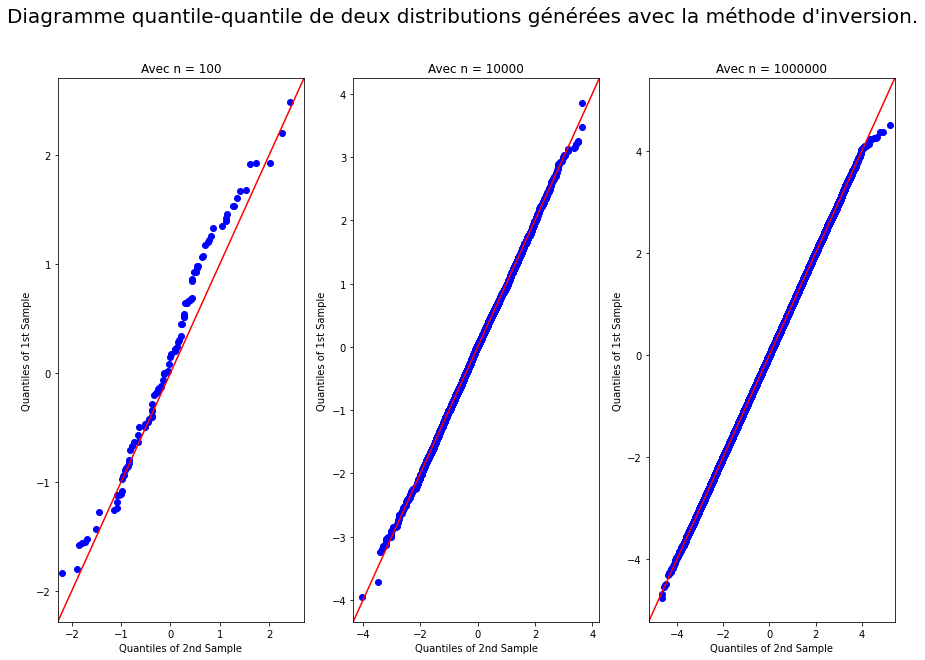

In [5]:
inline_qqplot(loi_normale_rep_inv, [100, 10_000, 1_000_000],
              'Diagramme quantile-quantile de deux distributions générées avec la méthode d\'inversion.')

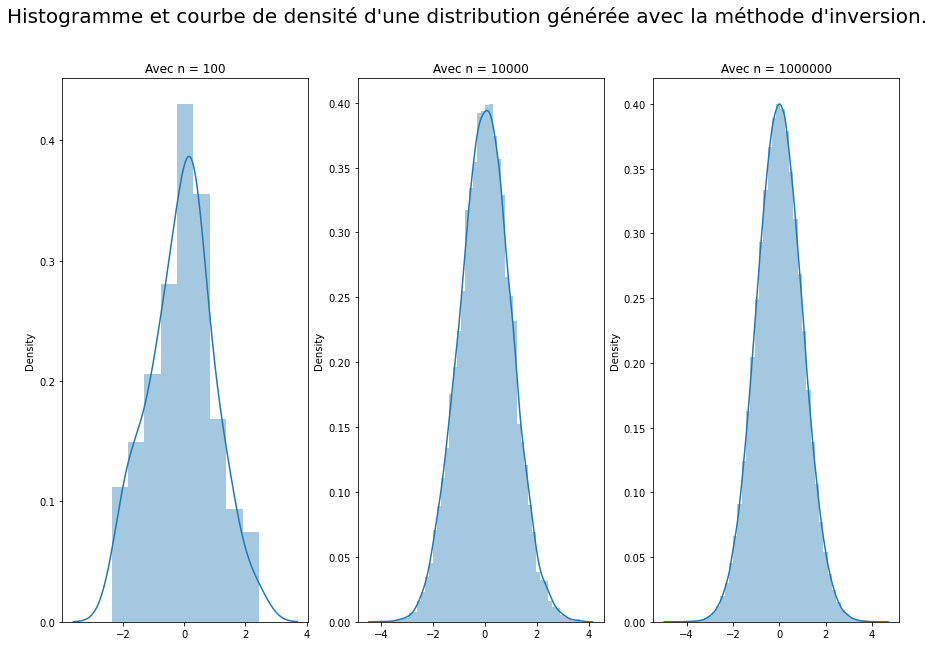

In [6]:
inline_distplot(loi_normale_rep_inv, [100, 10_000, 1_000_000],
                'Histogramme et courbe de densité d\'une distribution générée avec la méthode d\'inversion.')

### 2 - Théorèmre Central Limite<a name="theoreme_central_limite"></a>

Une application immédiate du Théorème Central Limite est la génération de variables aléatoires normales via une méthode très simple.

Partant de $n$ variables aléatoires $X_i$ de loi uniforme $U_{[0,1]}$, on peut générer une variable
aléatoire $Y$ ayant une loi normale de valeur moyenne $\bar{Y}$ et d'écart-type $\sigma_Y$ par la relation :

$$\large Y = \frac{\sum \limits_{i=1}^n (X_i) - \frac{n} {2}} {\sqrt{\frac{n} {12}}}$$

Voici l'implémentation de la méthode en Python :

In [7]:
def loi_normale_centrale_limite(n: int) -> np.ndarray:
    vect = []
    for i in range(n):
        x = runif(n)
        vect.append((sum(x) - n / 2) / sqrt(n / 12))
    return np.array(vect)

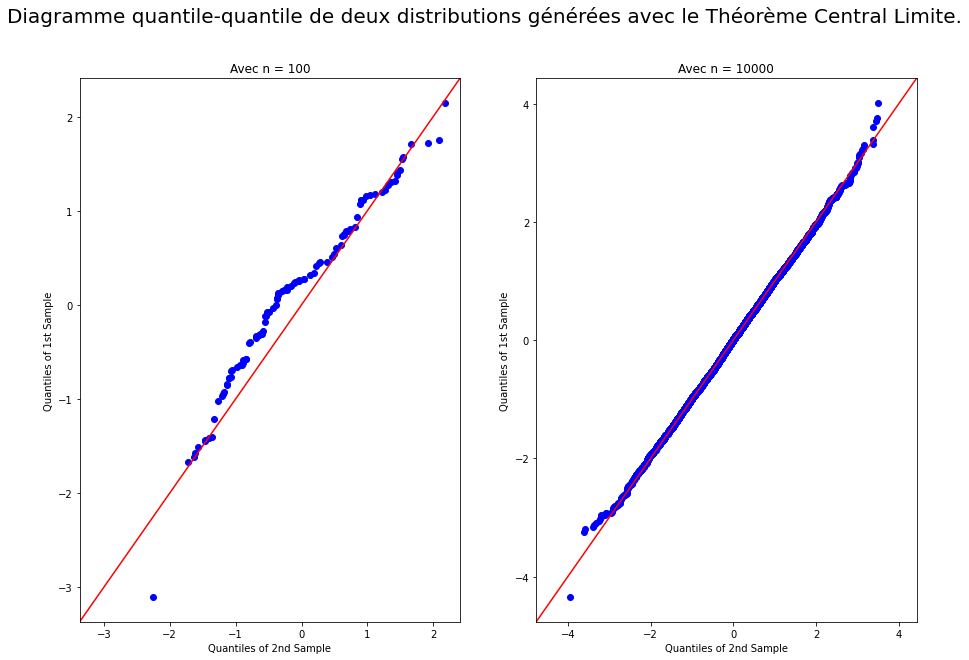

In [8]:
inline_qqplot(loi_normale_centrale_limite, [100, 10_000], 
              'Diagramme quantile-quantile de deux distributions générées avec le Théorème Central Limite.')

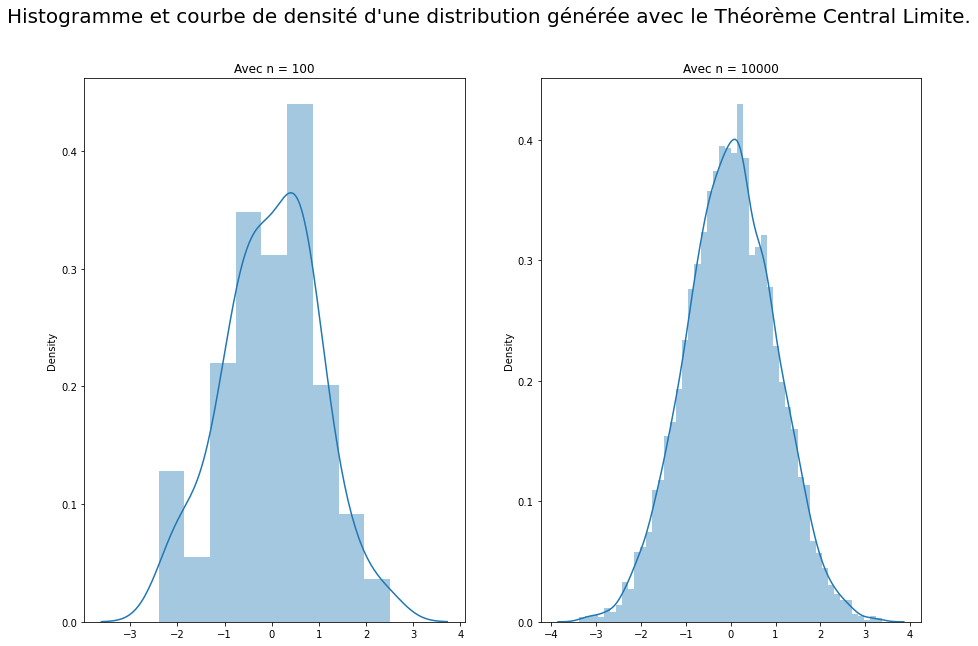

In [9]:
inline_distplot(loi_normale_centrale_limite, [100, 10_000],
                'Histogramme et courbe de densité d\'une distribution générée avec le Théorème Central Limite.')

### 3 - Méthode de Box et Muller<a name="box_muller"></a>

La
méthode
de
Box
et
Muller
permet
de
générer
un $2
n$-échantillon
de
la
loi $N(0, 1)$ à
partir
d’un
générateur
de
la
loi
uniforme.Si $U1$ et $U2$ sont
indépendantes
de
loi
uniforme
sur $]0, 1[$, alors le couple suivant est formé de variables gaussiennes indépendantes centrées de variance 1:

$$\large
{Y_0} = \sqrt
{-2
ln
{U_1}} \cos({2 \pi
{U_2}}) $$

$$\large
{Y_1} = \sqrt
{-2
ln
{U_1}} \sin({2 \pi
{U_2}}) $$

La
simulation
de
deux
variables
indépendantes
de
loi
uniforme
conduit
à
la
simulation
de
deux
variables
aléatoires
gaussiennes
standard
indépendantes.

Voici
l
'implémentation de la méthode en Python :

In [10]:
def box_muller(n: int):
    x0 = runif(n)
    x1 = runif(n)
    y0 = np.sqrt(-2 * np.log(x0)) * np.cos(2 * pi * x1)
    y1 = np.sqrt(-2 * np.log(x0)) * np.sin(2 * pi * x1)
    return y0, y1

In [11]:
# *** fonctions pour plot la méthode Box & Muller ***
def inline_qqplot_bm(lengths: List[int]) -> None:
    title = 'Diagramme quantile-quantile de deux distributions générées avec la méthode de Box et Muller.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        y0, y1 = box_muller(length)
        x = sm.ProbPlot(y0)
        y = sm.ProbPlot(y1)
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_distplot_bm(lengths: List[int]) -> None:
    title =  'Histogramme et courbe de densité d\'une distribution générée avec la méthode de Box et Muller.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        y0, y1 = box_muller(length)
        sns.distplot(y0, ax=axes[index])
        sns.distplot(y1, ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.legend(labels=['Y_0', 'Y_1'])
    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()
# ***

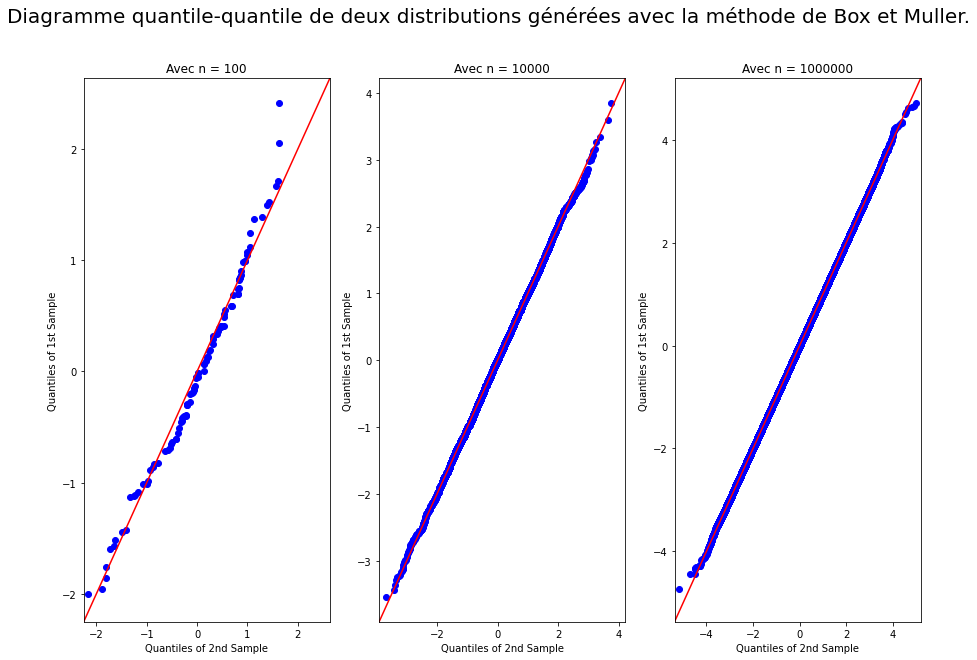

In [12]:
inline_qqplot_bm([100, 10_000, 1_000_000])

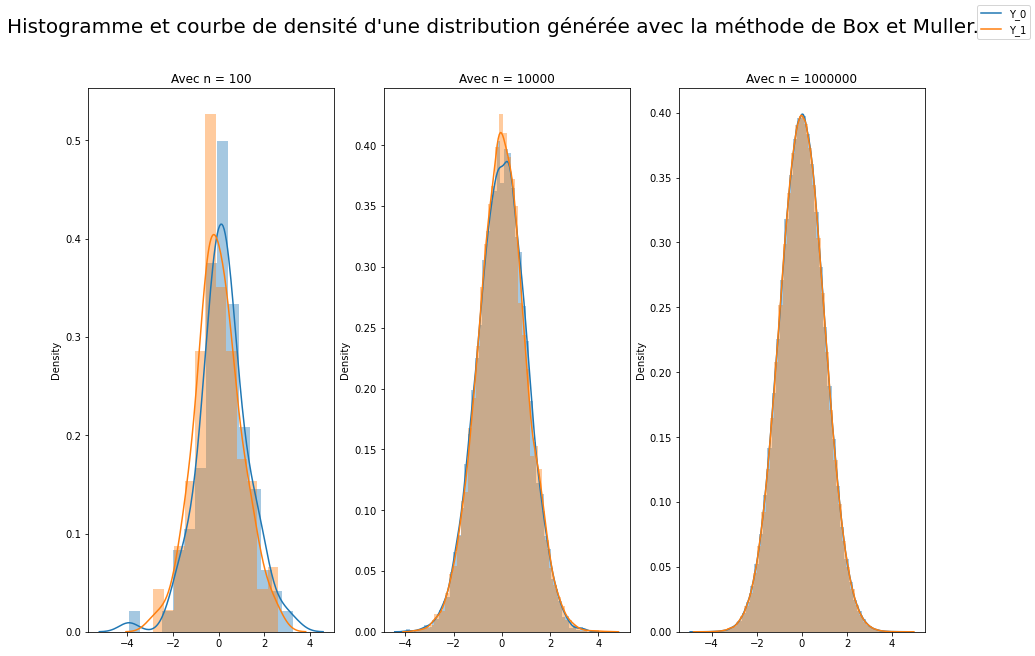

In [13]:
inline_distplot_bm([100, 10_000, 1_000_000])

### 4 - Méthode du rejet<a name="rejet"></a>

La méthode du rejet est une méthode de simulation utilisée lorsqu'il est compliqué de simuler des observations de la fonction désirée mais simple de le faire pour une fonction enveloppante.

Dans notre cas, nous voulons simuler des observations de la loi normale mais il n'existe pas de formule simple pour la fonction de répartition de cette loi. Pour ce faire, on utilise une fonction enveloppante de la loi normale. On dispose des enveloppes de Cauchy et de Laplace, définies ci-après. Ces deux enveloppes utilisent la fonction de densité de probabilité de la loi normale centrée réduite (que l'on veut envelopper), implémentée ci-dessous en Python :

In [14]:
def gaussian_density(x):
    a = 1 / (sqrt(2) * pi)
    b = exp(-x * x / 2)
    return a * b

#### a - Enveloppe de Cauchy<a name="cauchy"></a>

L'enveloppe de Cauchy est définie de la façon suivante :

$$\large \forall x\in \mathbb{R}, \frac {1} {\sqrt {2 \pi}} e^{\frac{-x^2} {2}} ≤ \sqrt{\frac {2 \pi} {e}}\frac{1} {\pi}  \frac{1} {1 + x^2}$$

Voici son implémentation en Python :

In [15]:
def cauchy(n: int) -> np.ndarray:
    res = [0 for _ in range(n)]
    c = sqrt(2 * pi / e)

    for i in range(n):
        u1 = random.uniform(0, 1)
        x = tan(pi * (u1 - 1 / 2))
        u2 = random.uniform(0, 1)
        res[i] = x

        while c * u2 / (pi * (1 + x * x)) > gaussian_density(x):
            u1 = random.uniform(0, 1)
            x = tan(pi * (u1 - 1 / 2))
            u2 = random.uniform(0, 1)
            res[i] = x

    return np.array(res)

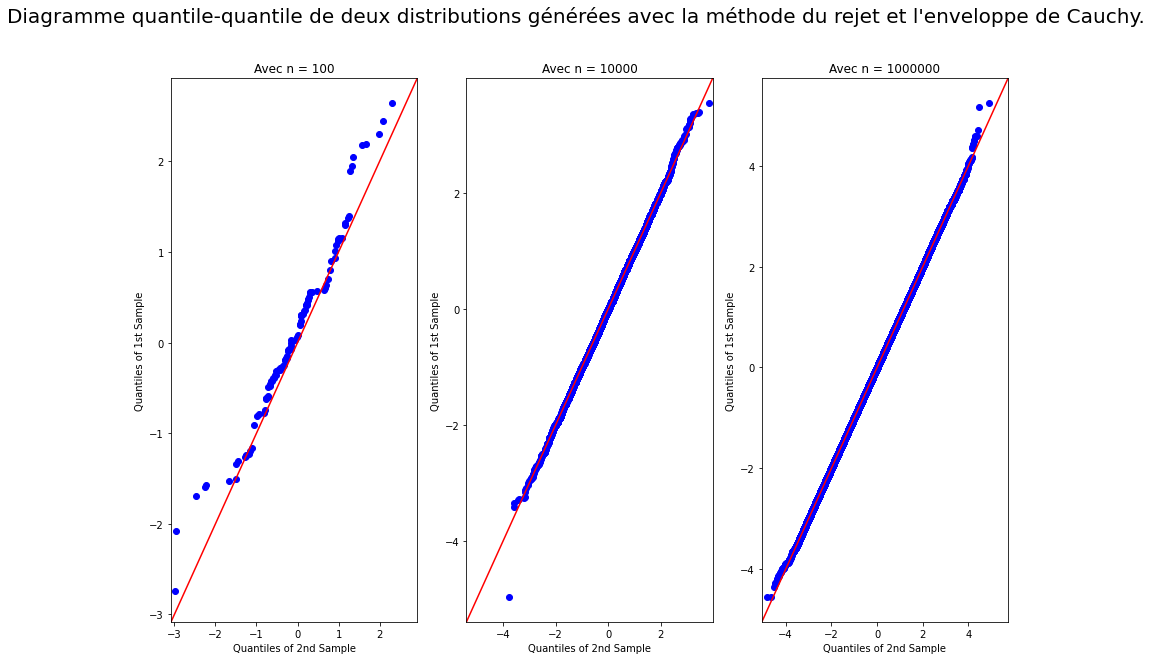

In [16]:
inline_qqplot(cauchy, [100, 10_000, 1_000_000],
              'Diagramme quantile-quantile de deux distributions générées avec la méthode du rejet et l\'enveloppe de Cauchy.')

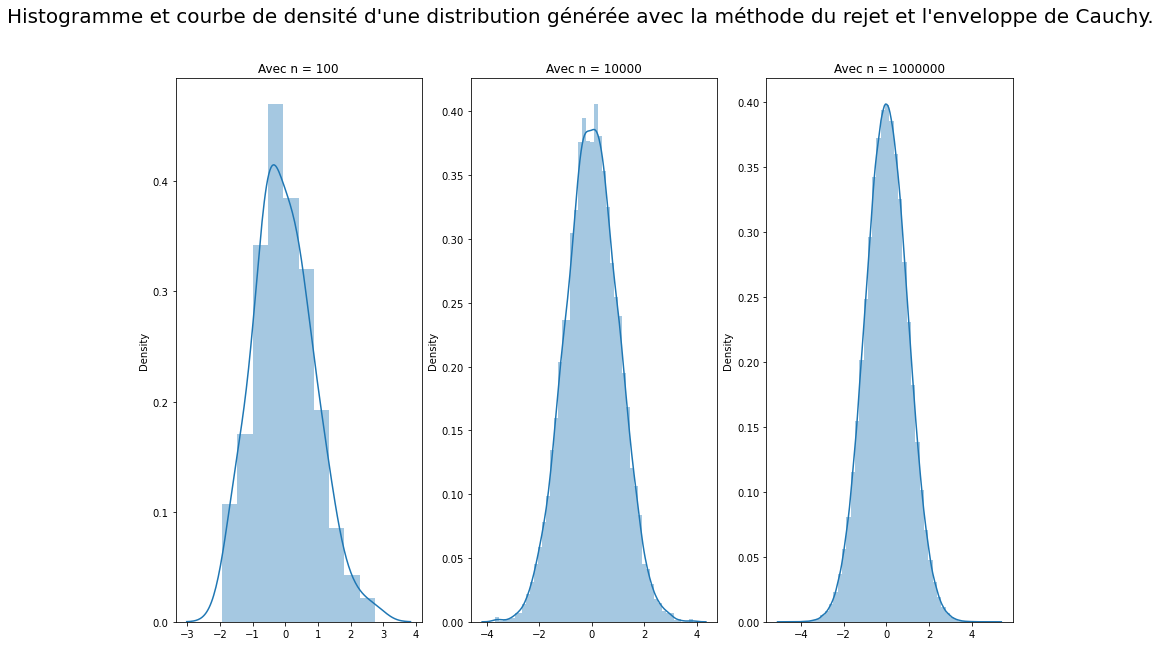

In [17]:
inline_distplot(cauchy, [100, 10_000, 1_000_000],
                'Histogramme et courbe de densité d\'une distribution générée avec la méthode du rejet et l\'enveloppe de Cauchy.')

#### b - Enveloppe de Laplace<a name="laplace"></a>

L'enveloppe de Laplace est définie de la façon suivante :

$$\large \forall x\in \mathbb{R}, \frac {1} {\sqrt {2 \pi}} e^{\frac{-x^2} {2}} ≤ 2 \sqrt{\frac {e} {2 \pi}} \frac{1} {2} e^{- |x|}$$

Voici son implémentation en Python :

In [18]:
def laplace(n: int) -> np.ndarray:
    res = [0 for _ in range(n)]
    c = 2 * (sqrt(e / 2 * pi))
    b = 1
    mu = 0

    for i in range(n):
        u1 = random.uniform(0, 1)
        x = mu - b * np.sign(u1 - 0.5) * log(1 - 2 * abs(u1 - 0.5))
        u2 = random.uniform(0, 1)
        res[i] = x

        while c * u2 * 1 / 2 * exp(-abs(x)) > gaussian_density(x):
            u1 = random.uniform(0, 1)
            x = mu - b * np.sign(u1 - 0.5) * log(1 - 2 * abs(u1 - 0.5))
            u2 = random.uniform(0, 1)
            res[i] = x

    return np.array(res)

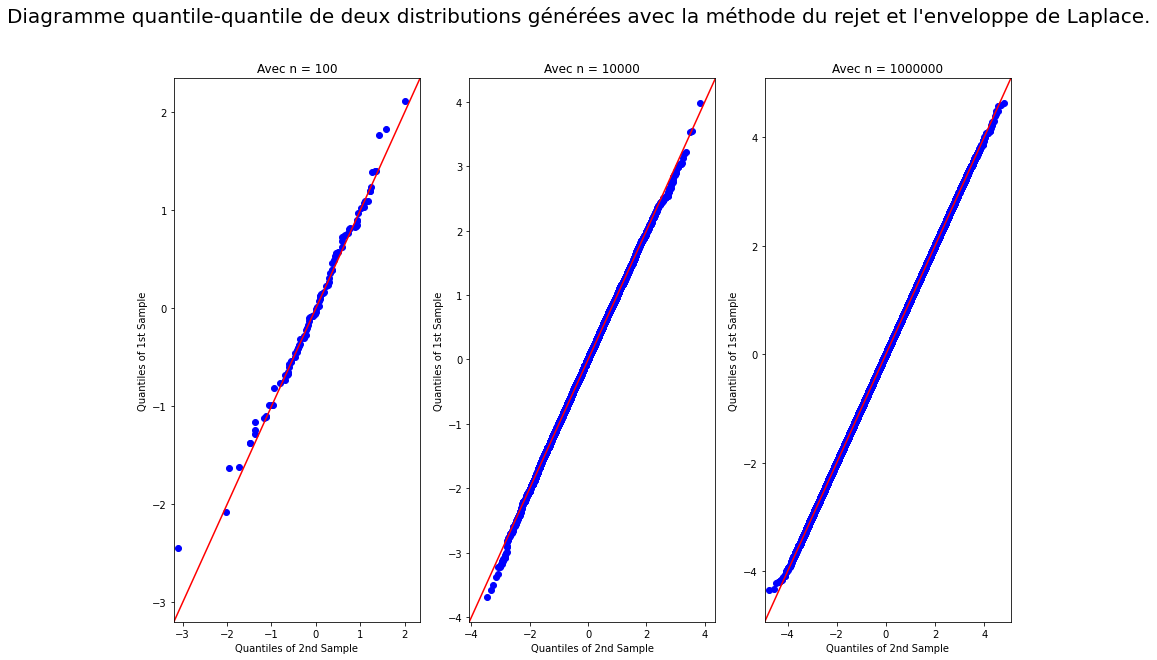

In [19]:
inline_qqplot(laplace, [100, 10_000, 1_000_000],
              'Diagramme quantile-quantile de deux distributions générées avec la méthode du rejet et l\'enveloppe de Laplace.')

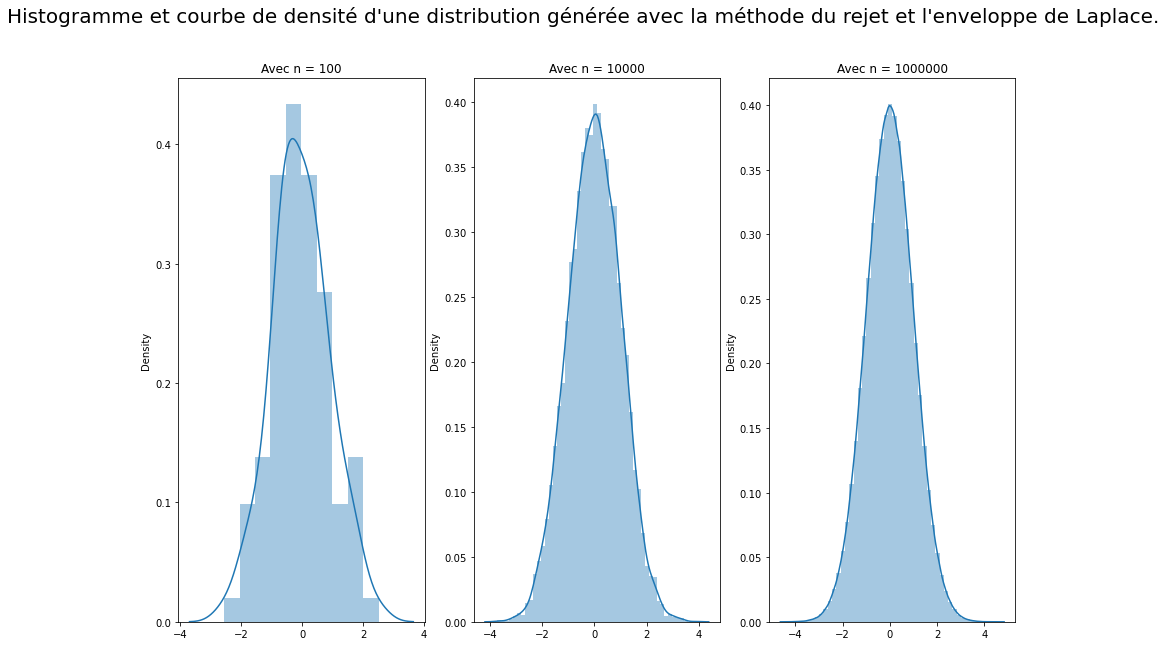

In [20]:
inline_distplot(laplace, [100, 10_000, 1_000_000],
                'Histogramme et courbe de densité d\'une distribution générée avec la méthode du rejet et l\'enveloppe de Laplace.')

## II - Comparaison des différentes méthodes de génération d'une loi normale<a name="comparaison"></a>

### 1 - Test d'équiprobabilité<a name="equiproba"></a>

In [21]:
NAMES = ['Loi Normale Inverse', 'Loi Normale Centrale Limite', 'Box et Muller (Y_0)', 'Box et Muller (Y_1)', 'Enveloppe de Cauchy',
         'Enveloppe de Laplace']
n = 10_000
y0, y1 = box_muller(n)
distributions = [loi_normale_rep_inv(n), loi_normale_centrale_limite(n), y0, y1, cauchy(n), laplace(n)]

data = {'Mean value': [mean(sublist) for sublist in distributions],
        'Quartile 25%': [np.percentile(sublist, 25) for sublist in distributions],
        'Quartile 50%': [np.percentile(sublist, 50) for sublist in distributions],
        'Quartile 75%': [np.percentile(sublist, 75) for sublist in distributions],
        'Variance': [np.var(sublist) for sublist in distributions],
        'Kurtosis (normalised)': [kurtosis(sublist) for sublist in distributions],
        'Skewness': [skew(sublist) for sublist in distributions]}

data = pd.DataFrame.from_dict(data, orient='index', columns=NAMES)
data['Valeur théorique'] = [0,  -0.675, 0,  0.675, 1, 0, 0]
data

,Loi Normale Inverse,Loi Normale Centrale Limite,Box et Muller (Y_0),Box et Muller (Y_1),Enveloppe de Cauchy,Enveloppe de Laplace,Valeur théorique
Mean value,-0.016914,-0.000721,-0.002568,0.009051,-0.002160,0.011592,0.000
Quartile 25%,-0.688673,-0.686912,-0.676610,-0.671508,-0.707825,-0.666624,-0.675
Quartile 50%,-0.015251,0.009644,-0.002783,-0.000012,0.009927,0.018403,0.000
Quartile 75%,0.660184,0.696470,0.681234,0.689109,0.684243,0.697037,0.675
Variance,0.974583,1.004141,0.998434,1.018000,1.025125,1.025110,1.000
Kurtosis (normalised),-0.016601,-0.024827,-0.001726,-0.045099,-0.056318,0.041403,0.000
Skewness,-0.008360,-0.030794,-0.024779,0.032684,0.007883,-0.031084,0.000


### 2 - Test de Student<a name="student"></a>

In [22]:
def student_test(samples: List[np.ndarray], samples_names: List[str], dist: np.ndarray, dist_name: str, alpha: float):
    for i, sample in enumerate(samples):
        t, p = ttest_ind(sample, dist)
        print(f'== {samples_names[i]} et {dist_name} ==\nt = {t}, pvalue = {p}')
        if (p > alpha):
            print("Les distributions sont identiques (Non-rejet de H0)\n")
        else :
            print("Les distributions sont différentes (Rejet de H0)\n")

normal_dist = [np.random.normal(0, 1) for _ in range(n)]
student_test(distributions, NAMES, normal_dist, 'np.random.normal', 0.05)

== Loi Normale Inverse et np.random.normal ==
t = -3.3072130353686817, pvalue = 0.0009439532147482209
Les distributions sont différentes (Rejet de H0)

== Loi Normale Centrale Limite et np.random.normal ==
t = -2.136378261873738, pvalue = 0.03266069768844189
Les distributions sont différentes (Rejet de H0)

== Box et Muller (Y_0) et np.random.normal ==
t = -2.2703394759355686, pvalue = 0.02319758445017431
Les distributions sont différentes (Rejet de H0)

== Box et Muller (Y_1) et np.random.normal ==
t = -1.4396146892890642, pvalue = 0.14999209411333175
Les distributions sont identiques (Non-rejet de H0)

== Enveloppe de Cauchy et np.random.normal ==
t = -2.2265861950873664, pvalue = 0.025986036423183676
Les distributions sont différentes (Rejet de H0)

== Enveloppe de Laplace et np.random.normal ==
t = -1.2581509250177394, pvalue = 0.2083518685045769
Les distributions sont identiques (Non-rejet de H0)



La valeur $t$ mesure l’ampleur de la différence par rapport à la variation de vos données d’échantillon. En d’autres termes, T est simplement la différence calculée représentée dans les unités de l’erreur type de la moyenne. Plus l’ampleur de T est grande, plus la preuve contre l’hypothèse nulle est grande. Cela signifie qu’il y a de plus grandes preuves qu’il y ait une différence significative. Plus T est proche de 0, plus il est probable qu’il n’y ait pas de différence significative.

## II - Cas particuliers : exemple de la  Loi de Poisson<a name="poisson"></a>

Pour générer des variables aléatoires à distribution de Poisson, on génére des variables exponentielles $E1, E2, …$ et on les additionne. Le plus petit nombre de variables exponentielles dont la somme dépasse 1 donne une variable aléatoire de Poisson. Autrement dit, si on définit $N$ comme le plus petit $n$ tel que :

$$\large \sum \limits_{k=1}^n E_k > 1 $$

alors $N$ est une variable aléatoire distribuée selon une loi de Poisson.

La génération de variables exponentielles se fait facilement en utilisant la méthode inverse. Pour $U(0, 1)$, la transformation :

$$\large E = \frac {− 1} {\lambda} ln(U) $$

donne une variable aléatoire exponentielle de moyenne $\frac {1} {\lambda}$. 

Voici son implémentation en Python :

In [23]:
def poisson(lmbd: int, n: int) -> np.ndarray:
    dist = np.zeros(n)  # init

    for i in range(n):

        exp_sum = 0
        counter = -1

        while exp_sum < 1:
            exp_sum += -(1 / lmbd) * np.log(random.uniform(0, 1))
            counter += 1

        dist[i] = counter

    return dist

In [24]:
# *** fonctions pour plot la loi de poisson ***
def inline_qqplot_poisson(lmbd: int, lengths: List[int]) -> None:
    title = f'Diagramme quantile-quantile de deux distributions générées avec l\'appromximation de la loi de Poisson (λ = {lmbd})'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        x = sm.ProbPlot(poisson(lmbd, length))
        y = sm.ProbPlot(poisson(lmbd, length))
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_histplot_poisson(lmbd: int, lengths: List[int]) -> None:
    title = f'Histogramme et courbe de densité d\'une distribution générée avec l\'appromximation de la loi de Poisson (λ = {lmbd})'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))
    
    for index, length in enumerate(lengths):
        sns.histplot(poisson(lmbd, length), ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')
        
    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()
# ***

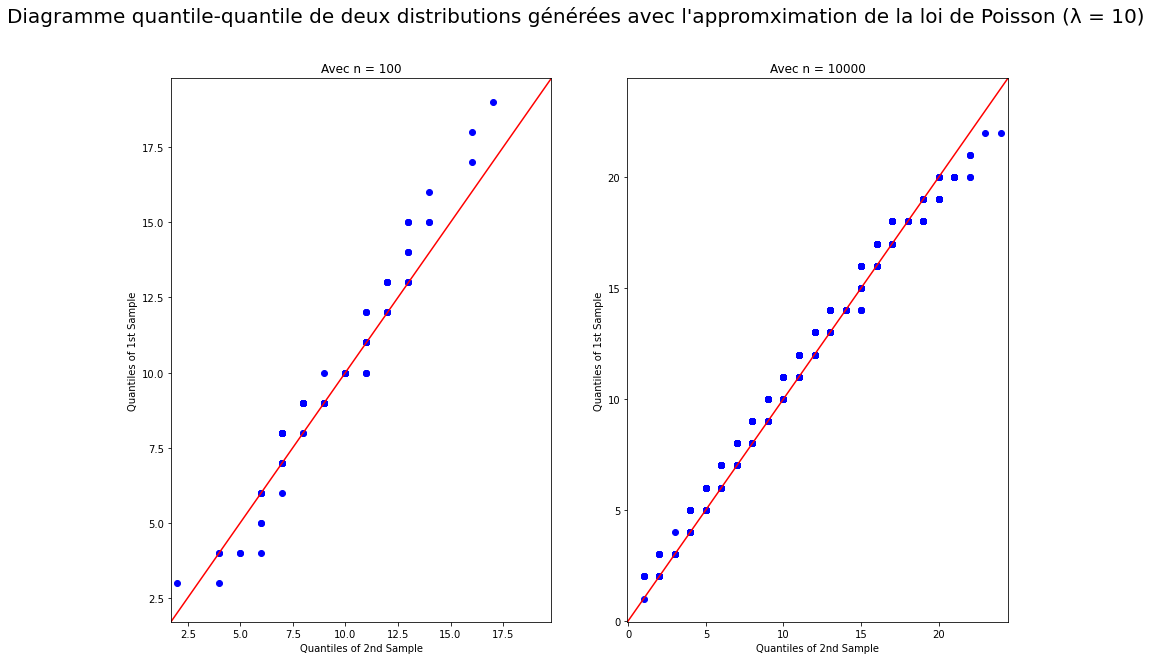

In [25]:
inline_qqplot_poisson(10, [100, 10_000])

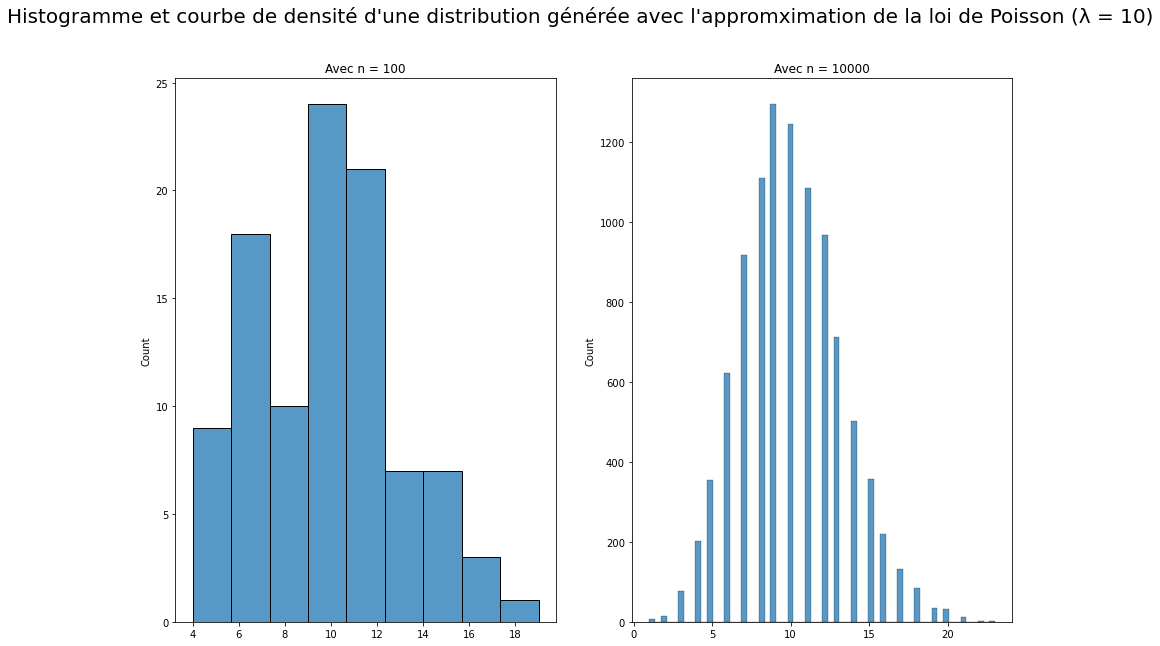

In [26]:
inline_histplot_poisson(10, [100, 10_000])

In [27]:
n = 10_000
lmbd = 10
dist = poisson(lmbd, n)

data = {'Mean value': mean(dist),
        'Quartile 25%': np.percentile(dist, 25),
        'Quartile 50% ': np.percentile(dist, 50),
        'Quartile 75%': np.percentile(dist, 75),
        'Variance': np.var(dist),
        'Kurtosis (normalised)': kurtosis(dist),
        'Skewness': skew(dist)}

pd.DataFrame.from_dict(data, orient='index', columns=[f'Poisson (λ = {lmbd})'])

,Poisson (λ = 10)
Mean value,9.994400
Quartile 25%,8.000000
Quartile 50%,10.000000
Quartile 75%,12.000000
Variance,9.812369
Kurtosis (normalised),0.162976
Skewness,0.330119
